In [1]:
import pandas as pd
import numpy as np
import pretty_midi as pm
import matplotlib.pyplot as plt
import librosa
import math
import itertools

In [9]:
class Sonify:
  
  def read_data(self, path):
    """Read the data from the given csv file path."""
    if not path.endswith(".csv"): # If provided path is not a valid csv file
      print("Invalid file path. Must be .csv file.")
      raise FileNotFoundError()
    self.df = pd.read_csv(path) # Loads csv file

    # Constants used to add cumulative seconds values in function inside loop
    entries_per_day = 12*24 # 12 samples an hour (every 5 mins), 24 hours in a day
    seconds_per_day = 60*60*24

    # Constants used to create Kp comparison value
    self.density_max = np.max(self.df["proton_density"])
    self.speed_max = np.max(self.df["speed"])

    for i, row in self.df.iterrows(): # Iterates through rows, replacing error data with the average of the previous value and the next valid (i.e., non-error) value
      # Data cleanup
      self.__cleanup_column("proton_density", row, i, threshold=0)
      self.__cleanup_column("speed", row, i, threshold=0)
      self.__cleanup_column("ion_temp", row, i, threshold=0)
      self.__cleanup_column("bz", row, i, threshold=-10)
      self.__cleanup_column("phi_angle", row, i, threshold=0)

      # Adding column for seconds since start of dataset
      self.__cumulative_seconds(i, entries_per_day, seconds_per_day)

      # Adds a column for our own synthetic variable and a column for the difference between that variable and the Kp index.
      self.__kp_comparison(i, row) # Not working fully yet

    # Just for testing...
    plt.plot(self.df["cumulative_secs"], self.df["kp_index"])
    plt.title("KP Index over time")
    plt.show()

    plt.plot(self.df["cumulative_secs"], self.df["kp_equiv"])
    plt.title("KP Equiv over time")
    plt.show()

    plt.plot(self.df["cumulative_secs"], self.df["kp_diff"])
    plt.title("KP difference over time")
    plt.show()

    # print("Lowest density value:", np.min(self.df["proton_density"]))
    # print("Lowest speed value:", np.min(self.df["speed"]))

    print(self.df)
    # read the data into df
    # TODO check if path is ok, file format is ok, load data into dataframe
  
  def __cumulative_seconds(self, i, entries_per_day, seconds_per_day):
    """Adds a value for the amount of seconds passed since the start of the dataset for the current index."""
    current_day_in_dataset = math.floor(i / entries_per_day) # Gets the number of seconds to the start of the current day by rounding down
    self.df.at[i, "cumulative_secs"] = (current_day_in_dataset*seconds_per_day) + self.df.at[i, "sec_of_day"] # Adds the start of the current day and the seconds elapsed in current day.

  def __kp_comparison(self, i, row):
    """Generates a synthetic variable based on raw data which is compared to the kp index, the difference can
    be a variable we can map to something (maybe a filter parameter?)"""
    density_scaled = self.df.at[i, "proton_density"]/self.density_max # The density of the current entry scaled 0-1
    speed_scaled = self.df.at[i, "speed"]/self.speed_max # The speed of the current entry scaled 0-1
    phi_angle = self.df.at[i, "phi_angle"]

    if i == 0: # Edge case for the first index
      local_start_index = 0
      local_end_index = 2
    elif i == len(self.df.index)-1: # Edge case for the last index
      local_start_index = len(self.df.index) - 3
      local_end_index = len(self.df.index) - 1
    else: # All other indices
      local_start_index = i - 1
      local_end_index = i + 1

    local_phi_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "phi_angle"])
    local_time_values = pd.Series.to_numpy(self.df.loc[local_start_index:local_end_index, "cumulative_secs"])

    kp_equiv = density_scaled + speed_scaled * 9
    self.df.at[i, "kp_equiv"] = kp_equiv
    self.df.at[i, "kp_diff"] = row["kp_index"] - kp_equiv

  def __cleanup_column(self, column_title, row, i, threshold=0):
    """Cleans up the data by finding erroneous data, then setting it to the average of the previous cell and the next non-error cell in the specified column."""
    if row[column_title] < threshold: # If data is below threshold i.e., is an error
      next_valid_value = self.__find_next_non_error_cell(i, column_title, threshold) # Find the next non-error cell in the column
      self.df.at[i, column_title] = round((self.df.at[i-1, column_title] + next_valid_value)*0.5, 1) # Sets the current cell to the average of the previous cell and the next non-error one

  def __find_next_non_error_cell(self, i, column_title, threshold):
    """Finds the next value in a column above a given threshold using recursion."""
    next_value = self.df.at[i+1, column_title]
    if next_value > threshold: # If the next cell is above the threshold i.e., not an error, return the next cell
      return next_value
    else: # If the next cell is also an error, run the function again to try the next cell down
      return self.__find_next_non_error_cell(i+1, column_title, threshold)

  def read_midi(self, path):

    """Read the midifile into a dataframe."""
    
    midi_data = pm.PrettyMIDI(path)
    if not path.endswith(".mid"):
      print("Invalid file path. Must be .mid file.")
      raise FileNotFoundError()
    else: print('MIDI-Fileload successful.')

    segments = (np.array(pm.PrettyMIDI.get_beats(midi_data,start_time=0.0)))
    print((segments))
    print(segments[-1])
    self.midi_grain_start = np.linspace(0, segments[-1], len(segments)*8)
    print(len(self.midi_grain_start))

  def read_audio(self, path):
    self.sr = 48000
    self.song = librosa.load(path, self.sr)[0]

  def grains_dataframe(self):
    # Idea for how to reference grains:

    self.grains_data = pd.DataFrame()

    song_len_samp = self.song.size # Length of current song in samples
    total_grains_in_song = len(self.df.index) # Number of grains in song (just the length of the dataset)
    grain_len = math.floor(song_len_samp / total_grains_in_song) # The length of each grain in samples

    print(song_len_samp)
    print(total_grains_in_song)
    print(grain_len)

    for i, row in self.df.iterrows():

      grain_start = i*grain_len # The start point of the current grain
      # print(grain_start)
      self.grains_data.at[i, "grain_start"] = grain_start # Adding grain start sample index to dataframe
      grain = self.song[grain_start:grain_start+grain_len] # Selecting grain data based on start and end points
      
      # Spectral Bandwidth
      spec_band = librosa.feature.spectral_bandwidth(y=grain, sr=self.sr, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
      self.grains_data.at[i, "spec_band"] = spec_band

      # Root Mean Square
      rms = librosa.feature.rms(y=grain, frame_length=grain_len, hop_length=grain_len)
      self.grains_data.at[i, "rms"] = rms

      # Mel Frequency Cepstrum Coefficients
      # mfcc = lib.feature.mfcc(grain, self.sr, 8, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
      # self.grains_data[i, "mfcc"] = mfcc

    print(self.grains_data)
        
      

In [ ]:
# Use this syntax to add methods to Sonify class in other cells

%%add_to Sonify
def function(self):
  pass

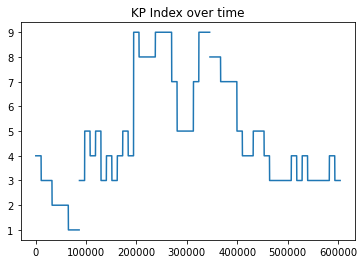

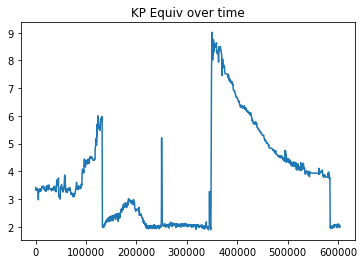

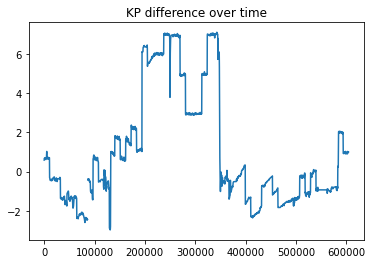

      year  month  day  time  sec_of_day  proton_density  speed  ion_temp  \
0     2003     10   27     0           0             2.3  475.8   94980.0   
1     2003     10   27     5         300             2.0  468.9   87100.0   
2     2003     10   27    10         600             2.1  461.9   98220.0   
3     2003     10   27    15         900             2.0  465.8   92240.0   
4     2003     10   27    20        1200             1.9  469.6  116960.0   
...    ...    ...  ...   ...         ...             ...    ...       ...   
2011  2003     11    2  2335       84900             4.4  279.4   94900.0   
2012  2003     11    2  2340       85200             3.3  275.2   80480.0   
2013  2003     11    2  2345       85500             3.8  277.4   72320.0   
2014  2003     11    2  2350       85800             3.4  276.8   49560.0   
2015  2003     11    2  2355       86100             3.0  276.3   72560.0   

       bz  phi_angle  kp_index  cumulative_secs  kp_equiv   kp_diff  
0    

c:\Users\Jack Hardwick\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Jack Hardwick\AppData\Local\Temp\ipykernel_23692\193141038.py:113: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.song = librosa.load(path, self.sr)[0]


10571295
2016
5243
      grain_start    spec_band           rms
0             0.0  4575.931254  8.320774e-02
1          5243.0  5389.468565  7.124205e-02
2         10486.0  2338.711567  5.468045e-02
3         15729.0  4171.104099  6.805190e-02
4         20972.0  4174.313439  7.238751e-02
...           ...          ...           ...
2011   10543673.0  7377.142552  6.105338e-04
2012   10548916.0  7093.998425  6.484789e-04
2013   10554159.0  3671.004543  2.426708e-07
2014   10559402.0  3503.646666  2.552282e-07
2015   10564645.0  3728.523779  2.617335e-07

[2016 rows x 3 columns]


In [10]:
sonify = Sonify()
sonify.read_data("./solar_wind_data_2003-10-27 - 2003-11-02_ACTUAL.csv")
sonify.read_midi("./corpus/02_Dido White Flag_adjusted_2.mid")
sonify.read_audio("./corpus/02_Dido White Flag.wav")
sonify.grains_dataframe()